In [1]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

In [15]:
from sqlmodel import create_engine, Session, select
from dotenv import load_dotenv
import os
from model.AICounselSummary import AICounselSummary, AICounselSummaryStatus
from model.MedicationCounsel import MedicationCounsel
from model.CounselSession import CounselSession, ScheduleStatus
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
import re
from langchain_openai import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

In [16]:

# macOS 기본 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 마이너스 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

load_dotenv()

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

In [5]:
DATABASE_URL = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(DATABASE_URL, echo=False)

In [7]:
with Session(engine) as session:

    start_datetime = datetime.strptime("2025-04-01 00:00", "%Y-%m-%d %H:%M")
    end_datetime = datetime.now()
    counsel_sessions = session.exec(select(CounselSession)
                          .where(CounselSession.scheduled_start_datetime >= start_datetime)
                          .where(CounselSession.scheduled_start_datetime <= end_datetime)
                          .where(CounselSession.status == ScheduleStatus.COMPLETED)).all()

    print(f"2025-04-01 부터 상담 수 : {len(counsel_sessions)}")
    
    print(f"중재 기록 작성 수 : {len([counsel_session for counsel_session in counsel_sessions 
                               if counsel_session.medication_counsel is not None])}")
    
    print(f"중재 기록 하이라이트 수 : {len([counsel_session for counsel_session in counsel_sessions 
                               if counsel_session.medication_counsel is not None
                               and counsel_session.medication_counsel.get_bold_text_in_counsel_record()])}")
    
    print(f"AI요약 시도 수 : {len([counsel_session for counsel_session in counsel_sessions 
                              if counsel_session.ai_counsel_summary is not None])}")
    
    print(f"AI요약 성공 수 : {len([counsel_session for counsel_session in counsel_sessions 
                              if counsel_session.ai_counsel_summary is not None 
                              and counsel_session.ai_counsel_summary.ai_counsel_summary_status == AICounselSummaryStatus.GPT_COMPLETE])}")


    counsel_session_times = [
    {
        "id": counsel_session.id,
        "scheduled_start_datetime": counsel_session.scheduled_start_datetime,
        "start_datetime": counsel_session.start_datetime,
        "end_datetime": counsel_session.end_datetime
    }
    for counsel_session in counsel_sessions]

    df_counsel_session_times = pd.DataFrame(counsel_session_times)
    df_counsel_session_times["duration_minutes"] = (df_counsel_session_times["end_datetime"] - df_counsel_session_times["start_datetime"]).dt.total_seconds() / 60
    df_counsel_session_times = df_counsel_session_times[(df_counsel_session_times["duration_minutes"] >= 5) & (df_counsel_session_times["duration_minutes"] <= 90)]
    print(df_counsel_session_times["duration_minutes"].describe())

    medication_counsels = [
    {
        "counsel_session_id": counsel_session.id,
        "medication_counsel_full_text": counsel_session.medication_counsel.get_full_counsel_record(),
        **({"ai_summary": counsel_session.ai_counsel_summary.get_ai_summary_result()} if counsel_session.ai_counsel_summary else {}),
        "bold_texts": counsel_session.medication_counsel.get_bold_text_in_counsel_record(),
    }
    for counsel_session in counsel_sessions
    if counsel_session.medication_counsel is not None
]
    
    
    df_medication_counsel = pd.DataFrame(medication_counsels)



2025-04-01 부터 상담 수 : 64
중재 기록 작성 수 : 60
중재 기록 하이라이트 수 : 7
AI요약 시도 수 : 41
AI요약 성공 수 : 41
count    53.000000
mean     31.446341
std      13.929615
min       5.308478
25%      26.287340
50%      31.080581
75%      39.858687
max      73.492664
Name: duration_minutes, dtype: float64


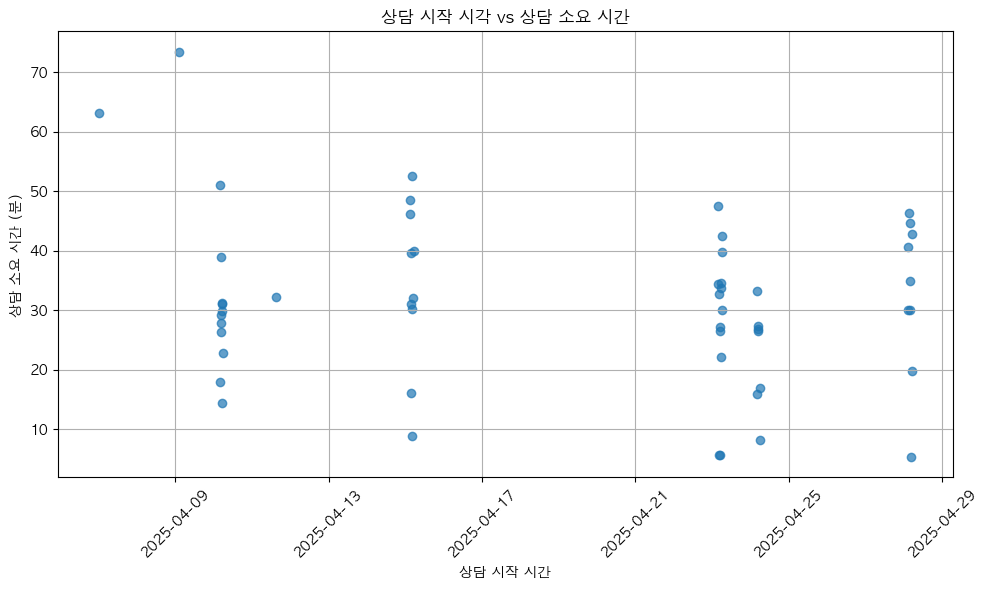

In [8]:
# duration_minutes가 존재하는 row만 사용
valid_df = df_counsel_session_times.dropna(subset=["start_datetime", "duration_minutes"])

plt.figure(figsize=(10, 6))
plt.scatter(valid_df["start_datetime"], valid_df["duration_minutes"], alpha=0.7)

plt.xlabel("상담 시작 시간")
plt.ylabel("상담 소요 시간 (분)")
plt.title("상담 시작 시각 vs 상담 소요 시간")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

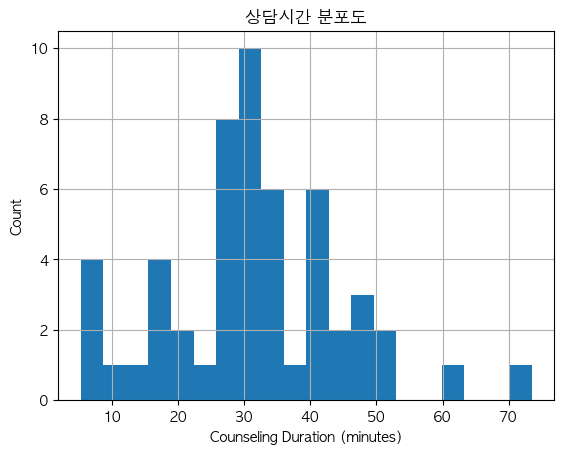

In [9]:
df_counsel_session_times["duration_minutes"].hist(bins=20)
plt.xlabel("Counseling Duration (minutes)")
plt.ylabel("Count")
plt.title("상담시간 분포도")
plt.show()

In [10]:
def remove_illegal_chars(text):
    if isinstance(text, str):
        # Excel에서 허용하지 않는 ASCII 제어 문자 제거 (\x00 ~ \x1F 중 탭(\x09), 줄바꿈(\x0A, \x0D) 제외)
        return re.sub(r"[\x00-\x08\x0b\x0c\x0e-\x1f]", "", text)
    return text

df_clean_medication_counsel = df_medication_counsel.map(remove_illegal_chars)
df_clean_medication_counsel.to_excel("상담기록_20250504.xlsx", index=False)

In [34]:
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

df_filtered_clean_medication_counsel = df_clean_medication_counsel[
    df_clean_medication_counsel["medication_counsel_full_text"].notna() &
    df_clean_medication_counsel["ai_summary"].notna() &
    (df_clean_medication_counsel["medication_counsel_full_text"].str.strip() != "") &
    (df_clean_medication_counsel["ai_summary"].str.strip() != "")
]

def calc_similarity(text1: str, text2: str) -> float:
    try:
        str1 = str(text1) if isinstance(text1, str) else ""
        str2 = str(text2) if isinstance(text2, str) else ""        
        emb1 = embedding_model.embed_query(text1 or "")
        emb2 = embedding_model.embed_query(text2 or "")
        return cosine_similarity([emb1], [emb2])[0][0]
    except Exception as e:
        print("에러:", e)
        return None

# 4. 유사도 점수 계산 및 컬럼 추가
df_filtered_clean_medication_counsel["similarity_score"] = [
    calc_similarity(row["medication_counsel_full_text"], row["ai_summary"])
    for _, row in tqdm(df_filtered_clean_medication_counsel.iterrows(), total=len(df_filtered_clean_medication_counsel))
]

# 5. 결과 확인
print(df_filtered_clean_medication_counsel[["counsel_session_id", "similarity_score"]].head())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:36<00:00,  1.03s/it]

           counsel_session_id  similarity_score
0  01JRC0H30QREBG156JC0H39GPP          0.343399
2  01JRC0WPGWT9259S0R3Z5TJTVQ          0.440607
5  01JRVPKSK9MKYFRCYT0SXX661F          0.681610
7  01JRBZP5B0WBYYSRF92XEX7KF6          0.308824
8  01JSDWWCC7085NRPSNPDVGP29Y          0.696209



/var/folders/9y/9h_f47pj0w58y9pl3zmsrp000000gn/T/ipykernel_33521/3745768541.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_clean_medication_counsel["similarity_score"] = [


In [35]:
df_filtered_clean_medication_counsel.describe()

,similarity_score
count,36.000000
mean,0.556049
std,0.173995
min,0.191688
25%,0.438565
50%,0.578526
75%,0.664554
max,0.939862


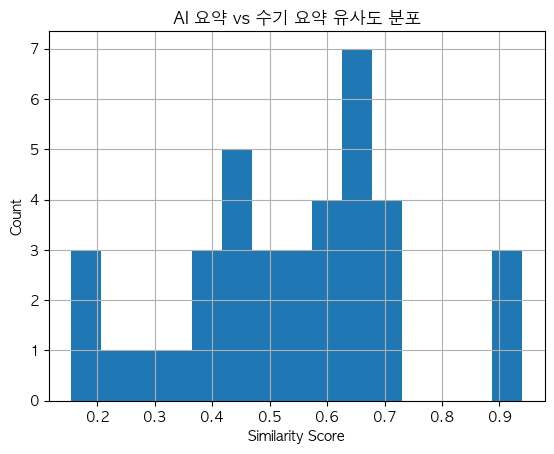

In [27]:
df_filtered_clean_medication_counsel["similarity_score"].hist(bins=15)
plt.title("AI 요약 vs 수기 요약 유사도 분포")
plt.xlabel("Similarity Score")
plt.ylabel("Count")
plt.grid(True)
plt.show()

/var/folders/9y/9h_f47pj0w58y9pl3zmsrp000000gn/T/ipykernel_33521/3921662073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_clean_medication_counsel["rating"] = df_filtered_clean_medication_counsel["similarity_score"].apply(get_rating)


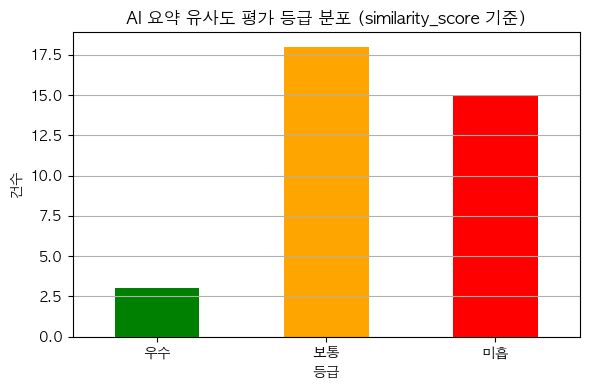

In [36]:
def get_rating(score):
    if score >= 0.75:
        return "우수"
    elif score >= 0.5:
        return "보통"
    else:
        return "미흡"

# 2. 등급 컬럼 추가
df_filtered_clean_medication_counsel["rating"] = df_filtered_clean_medication_counsel["similarity_score"].apply(get_rating)

# 3. 등급별 건수 집계
rating_counts = df_filtered_clean_medication_counsel["rating"].value_counts().reindex(["우수", "보통", "미흡"])

# 4. 시각화
plt.figure(figsize=(6, 4))
rating_counts.plot(kind="bar", color=["green", "orange", "red"])
plt.title("AI 요약 유사도 평가 등급 분포 (similarity_score 기준)")
plt.xlabel("등급")
plt.ylabel("건수")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

df_filtered_clean_medication_counsel.to_excel("상담기록_20250504_유사도_분석_결과.xlsx", index=False)